# Initial Setup

In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as py
import math as math
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression

all_companies_df = pd.read_csv("Levels_Fyi_Salary_Data.csv")

df = pd.read_csv("Levels_Fyi_Salary_Data.csv")
df.head()


,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN


# Cleaning the Data


In [2]:
number_of_entries_by_company = df.groupby("company")["timestamp"].count()
print(number_of_entries_by_company)

company
10x Genomics     6
23andMe          7
2U               7
3M              21
3m               3
                ..
zoom             1
zoominfo         1
zoox             3
zynga            1
 Google          1
Name: timestamp, Length: 1631, dtype: int64


Because we later want to use K-nearest neighbors to form a recommender system, we want companies with more than just a few entries. We want companies that have at least 100 entries.

In [3]:
statistics_by_company_df = np.round(pd.pivot_table(df, index = ["company"], values = ["totalyearlycompensation", "yearsofexperience", "yearsatcompany"], aggfunc='mean'))

statistics_by_company_df['counts'] = number_of_entries_by_company
statistics_by_company_df = statistics_by_company_df[~(statistics_by_company_df['counts'] <= 500)] # Limits the number of companies by removing companies with 500 or less rows in the dataset.

print(statistics_by_company_df)


                totalyearlycompensation  yearsatcompany  yearsofexperience  \
company                                                                      
Amazon                         227352.0             2.0                7.0   
Apple                          277930.0             3.0                8.0   
Bloomberg                      211050.0             2.0                5.0   
Capital One                    148808.0             2.0                6.0   
Cisco                          196243.0             5.0                9.0   
Facebook                       344527.0             1.0                7.0   
Google                         283290.0             3.0                7.0   
IBM                            137724.0             4.0                7.0   
Intel                          180525.0             7.0                9.0   
JPMorgan Chase                 136250.0             3.0                7.0   
LinkedIn                       307680.0             2.0         

In [4]:
# Removing Companies from DF irrelevant for analysis
mask = df['company'].isin(statistics_by_company_df.index)
df = df[mask]
df.head()


,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
5,6/21/2017 17:27:47,Microsoft,63,Software Engineer,208000,"Seattle, WA",8.5,8.5,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN


# Getting a feel for the Data

In [5]:
overall_statistics = [
                      [df['totalyearlycompensation'].min(),
                      df['totalyearlycompensation'].max(),
                      df['totalyearlycompensation'].std(),
                      df['totalyearlycompensation'].mean()
                      ], 
                      [df['yearsofexperience'].min(),
                       df['yearsofexperience'].max(),
                       df['yearsofexperience'].std(),
                       df['yearsofexperience'].mean()
                      ], 
                      [df['yearsatcompany'].min(),
                       df['yearsatcompany'].max(),
                       df['yearsatcompany'].std(),
                       df['yearsatcompany'].mean()
                      ]
                     ]

type_names = ['Yearly Compensation', 'Years of Experience', 'Years at Company']
statistic_names = ['Min', 'Max', 'Standard Deviation', 'Mean']

index_outer = 0;
for i in type_names:
    print(i + ':')
    index_inner = 0;
    for j in statistic_names:
        print('  - ' + j + ': ' + str(overall_statistics[index_outer][index_inner]))
        index_inner += 1;
    index_outer += 1;
    print('')
    

Yearly Compensation:
  - Min: 10000
  - Max: 4980000
  - Standard Deviation: 145791.82884859652
  - Mean: 240911.02322269013

Years of Experience:
  - Min: 0.0
  - Max: 45.0
  - Standard Deviation: 6.120999884216619
  - Mean: 7.465093200396334

Years at Company:
  - Min: 0.0
  - Max: 34.0
  - Standard Deviation: 3.495071362546766
  - Mean: 2.831256997770622



<AxesSubplot:xlabel='company'>

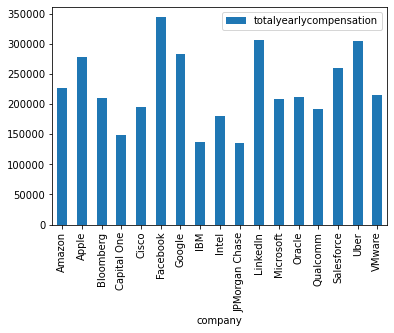

In [6]:
statistics_by_company_df.plot.bar(y='totalyearlycompensation')

<AxesSubplot:xlabel='company'>

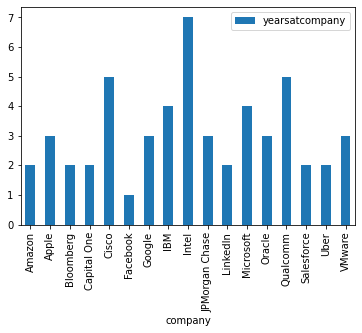

In [7]:
statistics_by_company_df.plot.bar(y='yearsatcompany')

<AxesSubplot:xlabel='company'>

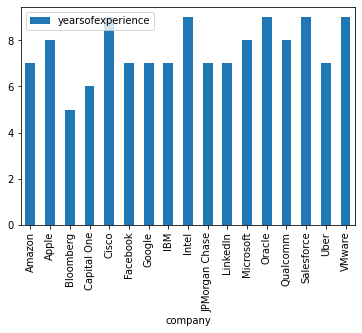

In [8]:
statistics_by_company_df.plot.bar(y='yearsofexperience')

<AxesSubplot:xlabel='company'>

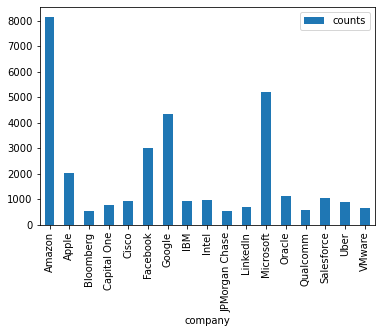

In [9]:
statistics_by_company_df.plot.bar(y='counts')

# Distribution of Education

Doctorate: 1114 | Masters: 7984 | Bachelors: 5465 

Some_College      0    1  Number of Degrees
num_degrees                                
0             17656  140              17796
1             14437    0              14437
2                63    0                 63 

 Highschool       0    1
num_degrees            
0            17664  132
1            14437    0
2               63    0 



<AxesSubplot:>

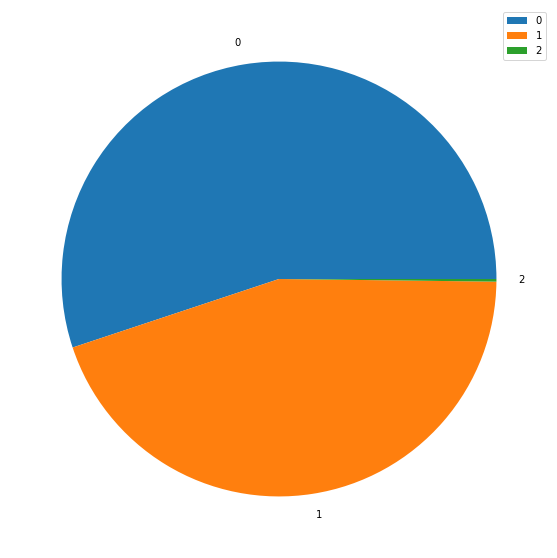

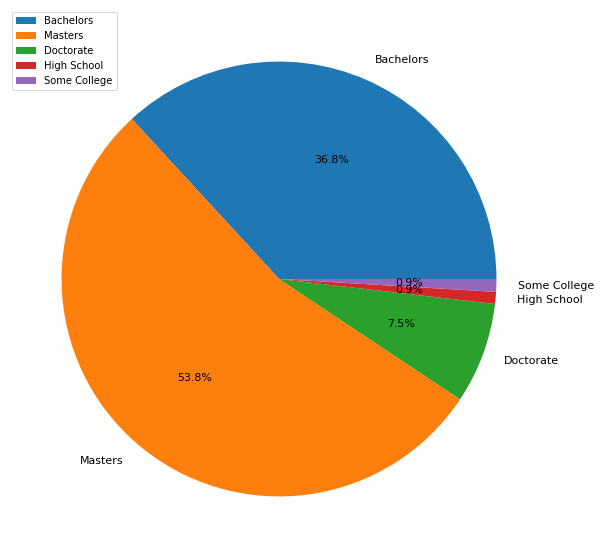

In [10]:
df["num_degrees"] = df["Bachelors_Degree"] + df["Masters_Degree"] + df["Doctorate_Degree"]

education_pivot_some_college = pd.crosstab(df['num_degrees'], df['Some_College'])
education_pivot_highschool = pd.crosstab(df['num_degrees'], df['Highschool'])

highschool_sum = df['Highschool'].sum()
some_college_sum = df['Some_College'].sum()
doctorate_sum = df['Doctorate_Degree'].sum()
masters_sum = df['Masters_Degree'].sum()
bachelors_sum = df['Bachelors_Degree'].sum()

print('Doctorate: ' + str(doctorate_sum) + ' | Masters: ' + str(masters_sum) + ' | Bachelors: ' + str(bachelors_sum), '\n')

education_pivot_some_college['Number of Degrees'] = education_pivot_some_college[0] + education_pivot_some_college[1]

print(education_pivot_some_college, '\n\n', education_pivot_highschool, '\n')

# Seeing if multiple have degrees have been Marked for a significant portion of sample (Not really, refer to second pie chart for more usable data)
education_pivot_some_college.plot.pie(y='Number of Degrees', ylabel='', figsize=(20, 10))

# Comparing the Highest Education People Received
data = [['Bachelors', bachelors_sum], ['Masters', masters_sum], ['Doctorate', doctorate_sum], ['High School', highschool_sum], ['Some College', some_college_sum]]
education_df = pd.DataFrame(data, columns = ['Type of Degree', 'Counts'])
education_df.set_index('Type of Degree', inplace=True)

education_df.plot.pie(y='Counts', figsize=(20, 10), ylabel='', autopct='%1.1f%%', fontsize=11)

A surprising amount of the workforce at these larger companies has a master's degree over a bachelors degree. We initially attempted to compare the number of degrees people have but it seems most people who filled out the survey only the selected the highest amount of education they receivied. We decided to shift some of our analysis to be based off of their highest level of education.

# Predict Yearly Income Based on Multiple Factors

### How do Years of Experience, Years at a Company, and the Number of Degrees you have affect Yearly Income?

In [11]:
print(len(df.index))

train = df.loc[:(len(df.index) * 0.8)].copy()
test = df.loc[(len(df.index) * 0.8 + 1):].copy()

model = LinearRegression()
model.fit(
    X=train[['yearsofexperience', 'yearsatcompany', 'num_degrees']],
    y=train['totalyearlycompensation']
)

model.predict(
    X=test[['yearsofexperience', 'yearsatcompany', 'num_degrees']]
)

print(model.coef_, model.intercept_, '\n\n', 3 * model.coef_[0] + 2 * model.coef_[1] + 1 * model.coef_[2] + model.intercept_)


32296
[11176.746204   -1612.76711213  4861.33217403] 167396.79079127536 

 202562.8273530375


Years of experience have the greatest positive impact on pay while the number of years spent at a company has the greatest negative impact. Having a degree does not seem nearly as important as having years of experience in the longrun.

### Based on the factors of your choice, what might your pay look like?

In [29]:
standard_inputs_list = ["yearsofexperience", "yearsatcompany"]
one_hot_inputs_list = ["location", "company", "title"]
all_inputs_list = ["yearsofexperience", "yearsatcompany", "location", "company", "title"]
questions_for_user = ["How many years of experience?", "How many years at the company?", "Location?", "Company?", "Title?"]

user_entries = []

index = 0
for i in questions_for_user:
    elements = df[all_inputs_list[index]].unique()
    if(len(elements) > 100):
        print(elements[:20])
    else:
        print(elements)
    user_entries.append(input(i))
    index += 1
    
standard_features = []
one_hot_features = []
all_features = []
    
if (user_entries[0] != ''):
    standard_features.append(standard_inputs_list[0])
    all_features.append(standard_inputs_list[0])
if (user_entries[1] != ''):
    standard_features.append(standard_inputs_list[1])
    all_features.append(standard_inputs_list[1])
if (user_entries[2] != ''):
    one_hot_features.append(one_hot_inputs_list[0])
    all_features.append(one_hot_inputs_list[0])
if (user_entries[3] != ''):
    one_hot_features.append(one_hot_inputs_list[1])
    all_features.append(one_hot_inputs_list[1])
if (user_entries[4] != ''):
    one_hot_features.append(one_hot_inputs_list[2])
    all_features.append(one_hot_inputs_list[2])

[ 1.5   8.    7.    5.    8.5  15.    4.    3.   12.   16.   10.    1.
  9.    2.   17.   14.    6.   20.   28.   13.   19.    0.5  11.    0.
 11.5   3.5   6.5  18.    2.5  21.    3.8   0.8   6.75 37.   24.   25.
 30.    5.5  32.   26.   23.   34.   27.   35.   22.   29.   33.   40.
 39.   31.   42.   41.    0.25 36.   38.   45.    4.5   0.6   1.4  10.5 ]


How many years of experience? 2


[ 1.5    0.     5.     3.     8.5   11.     4.     1.     6.    10.
  7.     2.     9.    15.    12.    17.     1.25   0.5    6.5    3.5
  5.5    8.     0.25   2.5   13.     3.8   18.    20.     4.5    2.75
 21.     0.1    4.4   16.     0.8   14.    30.    25.    19.     0.3
  7.5   15.5    0.6   24.     0.2    4.75   3.7    1.6    2.4    0.85
  1.8   34.     1.75   2.9    1.1    2.7    2.8   22.    26.     2.6
  0.33   4.8    2.3    0.7    1.2    4.2    3.3   23.    27.    28.
 33.     1.666  1.4  ]


How many years at the company? 0


['Redwood City, CA' 'Seattle, WA' 'Sunnyvale, CA' 'Mountain View, CA'
 'Redmond, WA' 'San Francisco, CA' 'Bellevue, WA' 'Menlo Park, CA'
 'London, EN, United Kingdom' 'Cupertino, CA' 'New York, NY'
 'Dublin, DN, Ireland' 'Hillsboro, OR' 'Cambridge, EN, United Kingdom'
 'Bangalore, KA, India' 'San Jose, CA' 'Washington, DC' 'Austin, TX'
 'Boston, MA' 'San Diego, CA']


Location? Seattle, WA


['Oracle' 'Amazon' 'Apple' 'Microsoft' 'Salesforce' 'Facebook' 'Uber'
 'Google' 'LinkedIn' 'Intel' 'Cisco' 'IBM' 'Qualcomm' 'Bloomberg'
 'Capital One' 'VMware' 'JPMorgan Chase']


Company? Amazon


['Product Manager' 'Software Engineering Manager' 'Software Engineer'
 'Data Scientist' 'Solution Architect' 'Technical Program Manager'
 'Human Resources' 'Product Designer' 'Marketing' 'Business Analyst'
 'Hardware Engineer' 'Recruiter' 'Sales' 'Mechanical Engineer'
 'Management Consultant']


Title? Software Engineer


In [30]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

if (len(standard_features) == 0 and len(one_hot_features) == 0):
    print('Cannot Perform Regression with No Features')
else:
    if (len(standard_features) != 0 and len(one_hot_features) != 0):
        ct = make_column_transformer(
            (StandardScaler(), standard_features),
            (OneHotEncoder(), one_hot_features),
            remainder="drop"  # all other columns in X will be dropped.
        )
    elif (len(standard_features)):
        ct = make_column_transformer(
            (StandardScaler(), standard_features),
            remainder="drop"  # all other columns in X will be dropped.
        )
    elif (len(one_hot_features) != 0):
            ct = make_column_transformer(
            (OneHotEncoder(), one_hot_features),
            remainder="drop"  # all other columns in X will be dropped.
        )
    else:
        print('Cannot Perform Operation')


    from sklearn.pipeline import make_pipeline
    from sklearn.neighbors import KNeighborsRegressor

    pipeline = make_pipeline(
        ct,
        KNeighborsRegressor(n_neighbors=10)
    )

    pipeline.fit(X=df[all_features], 
                 y=df["totalyearlycompensation"])

    x_test = pd.Series(dtype=float)
    if (user_entries[0] != ''):
        x_test["yearsofexperience"] = user_entries[0]
    if (user_entries[1] != ''):
        x_test["yearsatcompany"] = user_entries[1]
    if (user_entries[2] != ''):
        x_test["location"] = user_entries[2]
    if (user_entries[3] != ''):
        x_test["company"] = user_entries[3]
    if (user_entries[4] != ''):
        x_test["title"] = user_entries[4]

    print(pipeline.predict(X=pd.DataFrame([x_test])))

[187600.]


This regression was built with the idea that you can choose the factors that describe what you want from your job and predict the total yearly compensation of it. You have the option to inout how many years of experience you have, how long you have spent at a company, your desired location, the company you want to work for, and your title. At the very least, the number of years of experience should be input to get an idea of pay for your years of experience. Other factors can contribute to a higher or lower pay but every regression is different based on the factors you choose.

### How does pay vary with the amount of Education Received?

<AxesSubplot:xlabel='Type of Degree'>

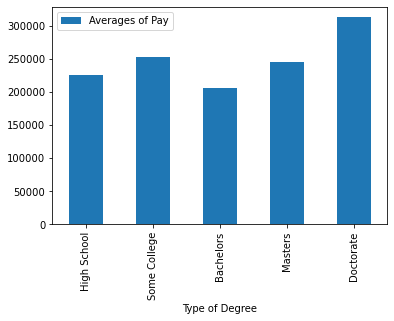

In [14]:
doctorate_df = df[~(df['Doctorate_Degree'] == 0)]
masters_df = df[~(df['Masters_Degree'] == 0)]
bachelors_df = df[~(df['Bachelors_Degree'] == 0)]
highschool_df = df[~(df['Highschool'] == 0)]
some_college_df = df[~(df['Some_College'] == 0)]

avg_of_doctorate = doctorate_df['totalyearlycompensation'].mean()
avg_of_masters = masters_df['totalyearlycompensation'].mean()
avg_of_bachelors = bachelors_df['totalyearlycompensation'].mean()
avg_of_some_college = some_college_df['totalyearlycompensation'].mean()
avg_of_highschool = highschool_df['totalyearlycompensation'].mean()

data = [['High School', avg_of_highschool], ['Some College', avg_of_some_college], ['Bachelors', avg_of_bachelors], ['Masters', avg_of_masters], ['Doctorate', avg_of_doctorate]]
degree_df = pd.DataFrame(data, columns = ['Type of Degree', 'Averages of Pay'])
degree_df.set_index('Type of Degree', inplace=True)

degree_df.plot.bar()

On average, having completed a high school education or having some college can result in a pay similar to that of a Master's degree. These are probably exceptional cases in which people have taken it on themselves to become really good at their field. Otherwise, pay clearly increases the further into you college education you go with Bachelors degrees getting paid least and Doctorates the most.

# Correlation Analysis

In [22]:
random = df.sample(10, replace=False, axis=0)
random

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,num_degrees
13195,11/18/2019 16:57:40,Qualcomm,Senior Staff Engineer,Hardware Engineer,280000,"San Diego, CA",23.0,6.0,RFIC,170000.0,...,0,0,0,0,0,0,0,NaN,Master's Degree,1
36446,12/2/2020 17:48:33,Google,L5,Software Engineer,396000,"San Francisco, CA",8.0,3.0,ML / AI,202000.0,...,0,0,0,1,0,0,0,White,PhD,1
54893,6/18/2021 11:39:27,Amazon,L6,Software Engineer,320000,"Seattle, WA",8.0,8.0,Distributed Systems (Back-End),160000.0,...,0,0,0,1,0,0,0,White,Master's Degree,1
10971,9/16/2019 13:43:31,Amazon,L4,Software Engineer,235000,"San Francisco, CA",4.0,4.0,Full Stack,0.0,...,0,0,0,0,0,0,0,NaN,NaN,0
24439,7/18/2020 14:40:55,Amazon,L6,Software Engineer,250000,"Bellevue, WA",10.0,8.0,Distributed Systems (Back-End),145000.0,...,0,0,0,0,0,0,0,NaN,NaN,0
35595,11/19/2020 12:32:25,Microsoft,L3,Software Engineer,205000,"Redmond, WA",12.0,12.0,Data,130000.0,...,0,0,0,0,0,0,0,NaN,NaN,0
11561,10/2/2019 2:23:28,Apple,ICT4,Software Engineer,356000,"Cupertino, CA",5.0,4.0,Backend,196000.0,...,0,0,0,0,0,0,0,NaN,NaN,0
19203,4/7/2020 11:37:05,Microsoft,59,Software Engineer,164000,"Redmond, WA",0.0,0.0,Distributed Systems (Back-End),109000.0,...,0,0,0,0,0,0,0,NaN,Master's Degree,1
939,8/22/2018 14:44:44,Amazon,L6 SDM,Software Engineering Manager,350000,"Seattle, WA",6.0,6.0,Distributed Systems (Back-End),0.0,...,0,0,0,0,0,0,0,NaN,NaN,0
38923,1/8/2021 1:33:40,Apple,ICT4,Software Engineer,213000,"Singapore, SG, Singapore",12.0,0.0,Data,140000.0,...,0,0,0,0,0,0,0,NaN,NaN,0


## Correlation Between Salary and Years at Company

In [23]:
company = pd.crosstab(random.totalyearlycompensation, random.yearsatcompany)

c, p, dof, expected = chi2_contingency(company)
c, p, dof

(50.00000000000001, 0.2814898743560321, 45)

With a degree of 40, our value on the significance table at 0.05 would be 55.76. Compared to our chi2 value of 42.50, our value is less than the significance table value. This means we accept the null hypothesis declaring that there is no correlation between the two variables.

## Correlation between Salary and Years of Experience

In [24]:
experience = pd.crosstab(random.totalyearlycompensation, random.yearsofexperience)


c, p, dof, expected = chi2_contingency(experience)
c, p, dof

(70.0, 0.25436730515271955, 63)

With a degree of 50, the chi2 value at 0.05 is 67.50. Compared to our chi2 value of 55.00, our value is less than the value in the significance table. This means we accept the null hypothesis declaring our two variables to have no correlation.

## Correlation Between Salary and Level of Education

In [25]:
education = pd.crosstab(random.totalyearlycompensation, random.num_degrees)


c, p, dof, expected = chi2_contingency(education)
c, p, dof

(10.000000000000002, 0.3504852123233616, 9)

With a degree of 8, our value for chi2 is 10.00. For the significance table value at 0.05, it is 15.51. Since our value is less than the significance table value, we can accept the null hypothesis and declare our two variables to have no correlation.

## Correlation Between Salary and Race

In [26]:
random["num_races"] = random["Race_Asian"] + random["Race_White"] + random["Race_Black"] + random["Race_Hispanic"] + random["Race_Two_Or_More"]

races = pd.crosstab(random.totalyearlycompensation, random.num_races)

c, p, dof, expected = chi2_contingency(races)
c, p, dof

(10.000000000000002, 0.3504852123233616, 9)

The significance table value for 0.05 at a degree of freedom 8 is 15.51. Because our chi2 value is 10.00, we can accept the null hypothesis. This means we can declare our two variables have no correlation